<a href="https://colab.research.google.com/github/LeoVal1/NLP-Embeddings-and-Sentiments/blob/main/NLP_Embeddings_and_Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Get the dataset

We're going to use a dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative). This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).

In [2]:
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

--2022-07-23 22:55:07--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 172.253.123.113, 172.253.123.102, 172.253.123.139, ...
Connecting to drive.google.com (drive.google.com)|172.253.123.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g9kp7lbg9gfka3d7i8ueapb43opkdir5/1658616900000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=b3f89c7c-d983-4a5e-bd92-65cc5f4d95e2 [following]
--2022-07-23 22:55:08--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g9kp7lbg9gfka3d7i8ueapb43opkdir5/1658616900000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=b3f89c7c-d983-4a5e-bd92-65cc5f4d95e2
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to d

In [3]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenize the dataset

Tokenize the dataset, including padding and OOV

In [20]:
vocab_size = 1000
embedding_dim = 16
#max_length = 100
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

## Review a Sequence

Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '0') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

good case excellent value 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Good case Excellent value.


## Train a Basic Sentiment Model with Embeddings

In [22]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 6)                 102       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [23]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 1s 5ms/step - loss: 0.6929 - accuracy: 0.5417 - val_loss: 0.6931 - val_accuracy: 0.4411
Epoch 2/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.6409 - val_loss: 0.6893 - val_accuracy: 0.7143
Epoch 3/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.7439 - val_loss: 0.6870 - val_accuracy: 0.7544
Epoch 4/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.7941 - val_loss: 0.6785 - val_accuracy: 0.6642
Epoch 5/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.7294 - val_loss: 0.6717 - val_accuracy: 0.7218
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.7232 - val_loss: 0.6588 - val_accuracy: 0.6742
Epoch 7/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.7646 - val_loss: 0.6472 - val_accuracy: 0.7143
Epoch 8/30
50/50 [==

## Visualize the training graph

You can use the code below to visualize the training and validation accuracy while you try out different tweaks to the hyperparameters and model.

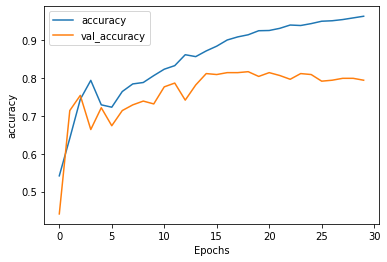

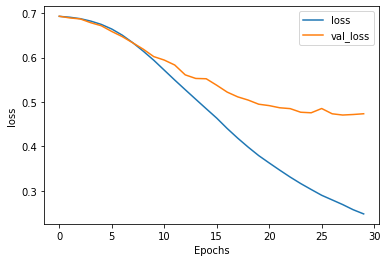

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Get files for visualizing the network

The code below will download two files for visualizing how your network "sees" the sentiment related to each word. Head to http://projector.tensorflow.org/ and load these files, then click the "Sphereize" checkbox.

In [25]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [26]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [27]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predicting Sentiment in New Reviews

Now that you've trained and visualized your network, take a look below at how we can predict sentiment in new reviews the network has never seen before.

In [28]:
# Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[0.75486577]


I hate spaghetti
[0.10758078]


Everything was cold
[0.2767954]


Everything was hot exactly as I wanted
[0.7176526]


Everything was green
[0.54356235]


the host seated us immediately
[0.75486577]


they gave us free chocolate cake
[0.75486577]


not sure about the wilted flowers on the table
[0.06791773]


only works when I stand on tippy toes
[0.75486577]


does not work when I stand on my head
[0.03060567]


